In [1]:
import sys
from pathlib import Path

# Add src to path
src_path = Path.cwd().parent / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

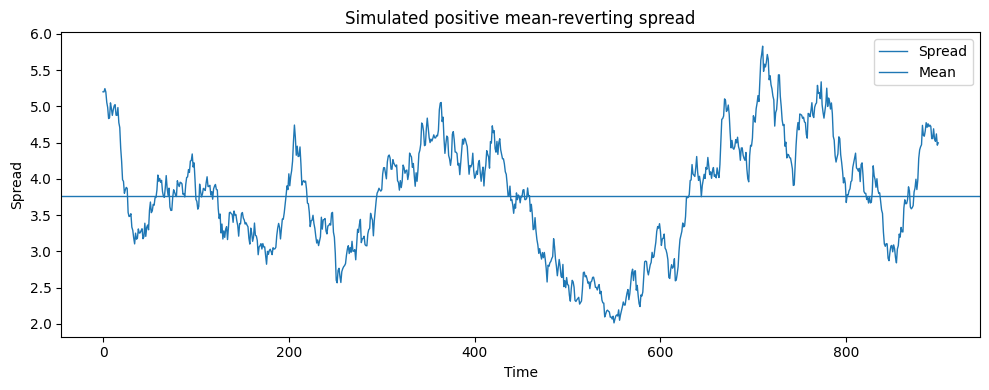

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_cir_spread(
    n=800, dt=1/252, s0=5.0, kappa=3.0, theta=5.0, sigma=0.9, seed=42
):
    """
    Positive mean-reverting spread around theta using CIR:
      dS = kappa(theta - S) dt + sigma sqrt(S) dW
    Full-truncation Euler to keep it >= 0 numerically.
    """
    rng = np.random.default_rng(seed)
    S = np.empty(n)
    S[0] = s0
    for t in range(1, n):
        z = rng.standard_normal()
        s_pos = max(S[t-1], 0.0)  # truncation for sqrt
        S[t] = S[t-1] + kappa*(theta - s_pos)*dt + sigma*np.sqrt(s_pos)*np.sqrt(dt)*z
        S[t] = max(S[t], 0.0)     # enforce non-negativity
    return S

# --- generate fake spread ---
S = simulate_cir_spread(n=900, dt=1/252, s0=5.2, kappa=2.5, theta=5.0, sigma=1.1, seed=7)

mu = np.mean(S)

# --- plot like the paper: mean + constant bands ---

plt.figure(figsize=(10,4))
plt.plot(S, lw=1, label="Spread")
plt.axhline(mu, lw=1, label="Mean")
plt.title("Simulated positive mean-reverting spread")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.legend()
plt.tight_layout()
plt.show()

Intro:
In the main paper, trading strategies (A, B, C) are defined with fixed opening thresholds and a simple closing rule:

close the position when the spread crosses the mean.

This appendix asks:

What if the closing rule itself is flexible and optimized?

So the extension generalizes the exit rule, not the entry rule.

**The key idea: introduce a flexible closing boundary**

In [20]:
from pairs_ssm.trading.strategy import (
    strategy_E_signals, 
    strategy_D_signals, 
    find_trades,      # For Strategy A and C
    find_trades_safe
)

S = pd.Series(S, index=range(len(S)))
delta = 0.1
sigma = np.std(S)

k = 1 #nb of std 
U = mu + k*sigma
L = mu - k*sigma
C = mu

C_minus = C - delta * U
C_plus  = C + delta * U

print(C)
print(U)

3.7633821770586695
4.5514070943454294


# I: BENCHMARK TRADING STRATS

## Strat D

Pour résumer, strat D = Generalisation / Extension de la strat A
"I assume we close the trade when the spread crosses (mean − ∆) from above (or (mean + ∆) from below) for a parameter ∆, while keeping the threshold for opening a trade unchanged"

-     Entry: same as Strategy A (open when spread hits ±U)
-     Exit: close when spread crosses


(mean − Δ (if short)
mean + Δ (if long))

Special cases:

-    δ = 0 → Strategy A (close at the mean)
-    δ = 1 → Strategy B (close at the opposite boundary)

So Strategy D nests A and B as special cases.

In [21]:
signals_D = strategy_D_signals(S, U, L, C_minus=C_minus, C_plus=C_plus)
trades_D  = find_trades_safe(signals_D)
print(trades_D[:5], "n_trades =", len(trades_D))


[{'entry': 0, 'exit': 32, 'type': 'short'}, {'entry': 167, 'exit': 204, 'type': 'long'}, {'entry': 206, 'exit': 229, 'type': 'short'}, {'entry': 250, 'exit': 306, 'type': 'long'}, {'entry': 343, 'exit': 463, 'type': 'short'}] n_trades = 9


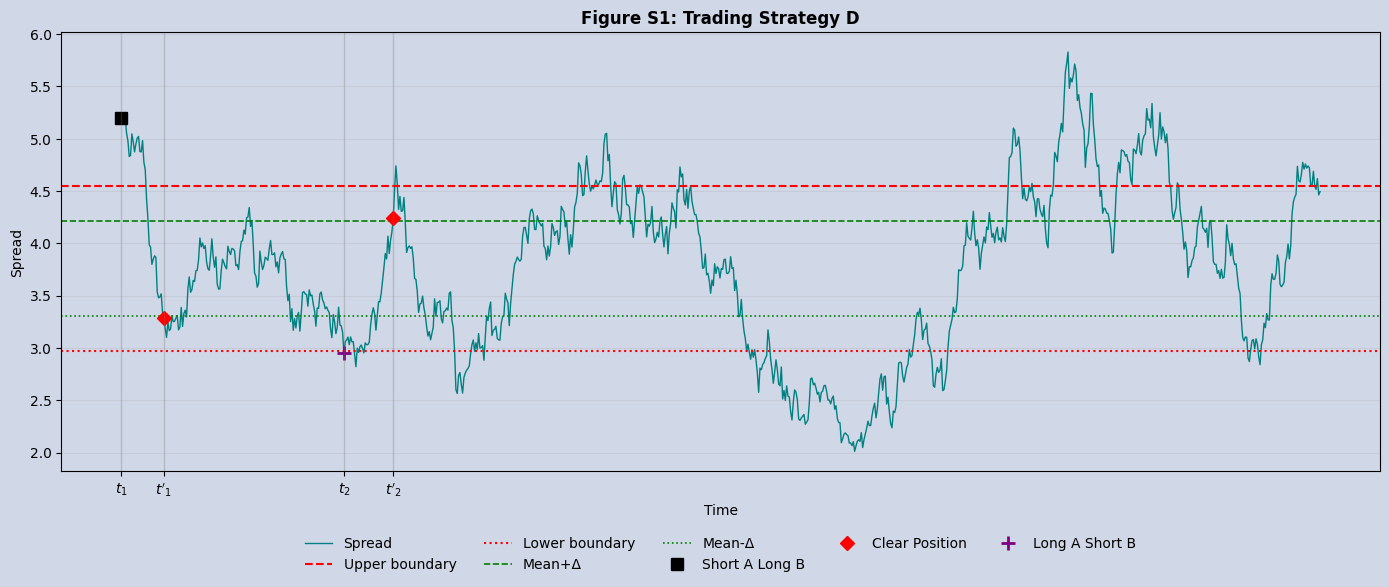

In [22]:
import matplotlib.pyplot as plt

# --- Plot Figure S1: Strategy D (paper-like legend) ---
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Spread
ax.plot(S.index, S.values, color='teal', linewidth=1, label='Spread')

# Thresholds (constant here)
ax.axhline(y=U,       color='red',   linestyle='--', linewidth=1.5, label='Upper boundary')
ax.axhline(y=L,       color='red',   linestyle=':',  linewidth=1.5, label='Lower boundary')
ax.axhline(y=C_plus,  color='green', linestyle='--', linewidth=1.2, label='Mean+Δ')
ax.axhline(y=C_minus, color='green', linestyle=':',  linewidth=1.2, label='Mean-Δ')

# Mark entry/exit points with paper symbols + robust legend labels
shown_short = False
shown_long  = False
shown_clear = False

# Build x-axis tick labels: t1, t1', t2, t2', ...
tick_pos, tick_lab = [], []

for i, trade in enumerate(trades_D[:2], start=1):  # paper shows 2 trades (t1,t1',t2,t2')
    entry = trade['entry']
    exit_ = trade['exit']

    entry_val = S.loc[entry]
    exit_val  = S.loc[exit_]

    # Entry markers
    if trade['type'] == 'short':
        # ■ Short A Long B
        ax.plot(entry, entry_val, marker='s', linestyle='None', color='black',
                markersize=8, label='Short A Long B' if not shown_short else '')
        shown_short = True
    else:
        # + Long A Short B
        ax.plot(entry, entry_val, marker='+', linestyle='None', color='purple',
                markersize=10, mew=2, label='Long A Short B' if not shown_long else '')
        shown_long = True

    # Exit marker: ◆ Clear Position
    ax.plot(exit_, exit_val, marker='D', linestyle='None', color='red',
            markersize=7, label='Clear Position' if not shown_clear else '')
    shown_clear = True

    # Vertical lines at entry/exit (paper-like)
    ax.axvline(entry, color='grey', alpha=0.25, linewidth=1)
    ax.axvline(exit_, color='grey', alpha=0.25, linewidth=1)

    # Custom ticks
    tick_pos += [entry, exit_]
    tick_lab += [rf"$t_{i}$", rf"$t'_{i}$"]

# Replace x-axis with t_i / t'_i
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_lab)

# Titles/labels
ax.set_title('Figure S1: Trading Strategy D', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')

# Legend (deduplicate labels)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          loc='upper center', bbox_to_anchor=(0.5, -0.12),
          ncol=5, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Strat E

In [23]:
signals_E = strategy_E_signals(S, U, L, C_minus=C_minus, C_plus=C_plus)
trades_E  = find_trades_safe(signals_E)
print(trades_E[:5], "n_trades =", len(trades_E))

[{'entry': 19, 'exit': 32, 'type': 'short'}, {'entry': 168, 'exit': 175, 'type': 'long'}, {'entry': 177, 'exit': 178, 'type': 'long'}, {'entry': 179, 'exit': 182, 'type': 'long'}, {'entry': 183, 'exit': 204, 'type': 'long'}] n_trades = 33


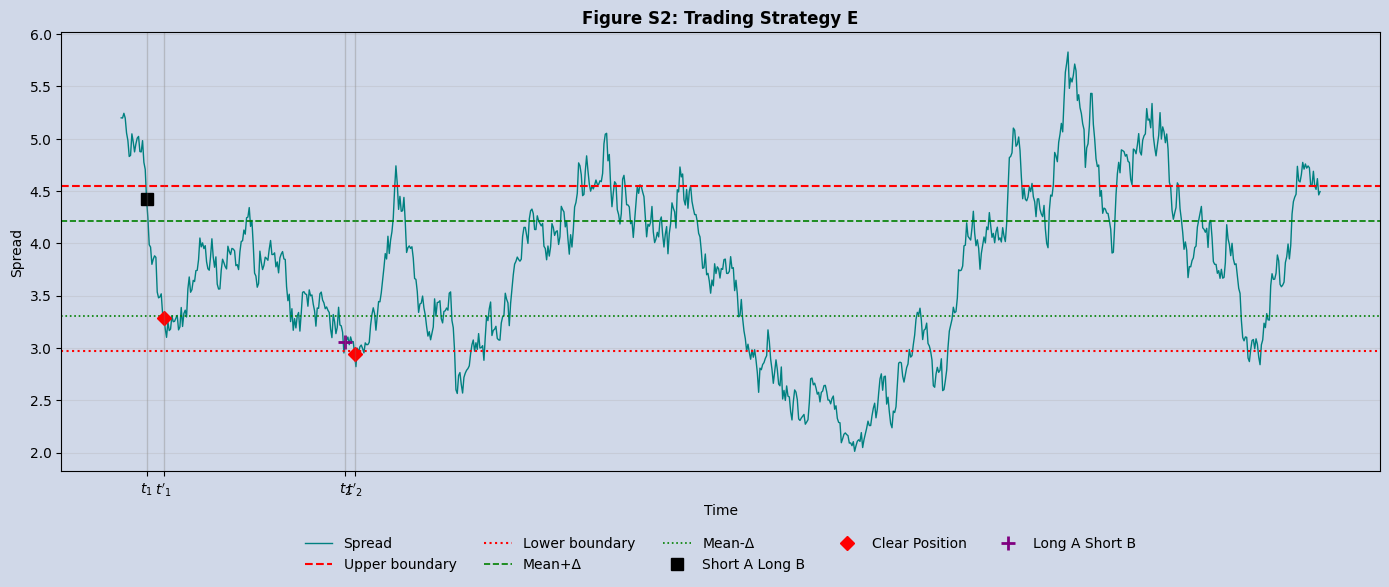

In [24]:
import matplotlib.pyplot as plt

# --- Plot Figure S2: Strategy E (paper-like legend) ---
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Spread
ax.plot(S.index, S.values, color='teal', linewidth=1, label='Spread')

# Thresholds
ax.axhline(y=U,       color='red',   linestyle='--', linewidth=1.5, label='Upper boundary')
ax.axhline(y=L,       color='red',   linestyle=':',  linewidth=1.5, label='Lower boundary')
ax.axhline(y=C_plus,  color='green', linestyle='--', linewidth=1.2, label='Mean+Δ')
ax.axhline(y=C_minus, color='green', linestyle=':',  linewidth=1.2, label='Mean-Δ')

# Mark entry/exit points with paper symbols + robust legend labels
shown_short = False
shown_long  = False
shown_clear = False

# Build x-axis tick labels: t1, t1', t2, t2', ...
tick_pos, tick_lab = [], []

for i, trade in enumerate(trades_E[:2], start=1):  # show 2 trades like the paper
    entry = trade['entry']
    exit_ = trade['exit']

    entry_val = S.loc[entry]
    exit_val  = S.loc[exit_]

    # Entry markers
    if trade['type'] == 'short':
        # ■ Short A Long B
        ax.plot(entry, entry_val, marker='s', linestyle='None', color='black',
                markersize=8, label='Short A Long B' if not shown_short else '')
        shown_short = True
    else:
        # + Long A Short B
        ax.plot(entry, entry_val, marker='+', linestyle='None', color='purple',
                markersize=10, mew=2, label='Long A Short B' if not shown_long else '')
        shown_long = True

    # Exit marker: ◆ Clear Position
    ax.plot(exit_, exit_val, marker='D', linestyle='None', color='red',
            markersize=7, label='Clear Position' if not shown_clear else '')
    shown_clear = True

    # Vertical lines at entry/exit
    ax.axvline(entry, color='grey', alpha=0.25, linewidth=1)
    ax.axvline(exit_, color='grey', alpha=0.25, linewidth=1)

    # Custom ticks
    tick_pos += [entry, exit_]
    tick_lab += [rf"$t_{i}$", rf"$t'_{i}$"]

# Replace x-axis with t_i / t'_i
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_lab)

# Titles/labels
ax.set_title('Figure S2: Trading Strategy E', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')

# Legend (deduplicate labels)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          loc='upper center', bbox_to_anchor=(0.5, -0.12),
          ncol=5, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
